# DengAI Analysis Part 4b - Reducing number of PCA components

By: Chengyi (Jeff) Chen, under guidance of CSCI499: AI for Social Good Teaching Assistant - Aaron Ferber

---
## Content

In this notebook, we will apply some feature selection and engineering techniques in order to boost out predictions.

<a id="imports"></a>

---
## Library Imports

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import subprocess
import statsmodels.formula.api as sm
from statsmodels import stats as sms
import statsmodels as statsmodels
from scipy import stats
import os
from collections import Counter
from sklearn import model_selection, kernel_ridge, linear_model, metrics, feature_selection, preprocessing
from os import listdir
from os.path import isfile, join, isdir
import warnings
warnings.filterwarnings('ignore')

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline

In [2]:
# DengAI dataset URLs
dengai_features_url = 'https://www.dropbox.com/s/1kuf94b4mk6axyy/dengue_features_train.csv'
dengai_labels_url = 'https://www.dropbox.com/s/626ak8397abonv4/dengue_labels_train.csv'
dengai_test_features_url = 'https://s3.amazonaws.com:443/drivendata/data/44/public/dengue_features_test.csv'

In [3]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

<a id="clean_feats"></a>

---
## Cleaned Features

In [51]:
sj_X = pd.read_csv('./data/dengai/cleaned/sj_X.csv', index_col='week_start_date')
sj_y = pd.read_csv('./data/dengai/cleaned/sj_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')
iq_X = pd.read_csv('./data/dengai/cleaned/iq_X.csv', index_col='week_start_date')
iq_y = pd.read_csv('./data/dengai/cleaned/iq_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')

<a id="power_transform"></a>

---
## Yeo-Johnson Transform the Labels

In [5]:
from sklearn.preprocessing import PowerTransformer

# Applying yeo-johnson transform on the labels of City sj 
# REMEMBER TO INVERSE TRANSFORM YOUR Y_PREDS
# sj_pwr = PowerTransformer()
# sj_y = pd.Series(sj_pwr.fit_transform(sj_y).flatten(), index=sj_y.index)

# Applying yeo-johnson transform on the labels of City iq 
# REMEMBER TO INVERSE TRANSFORM YOUR Y_PREDS
# iq_pwr = PowerTransformer()
# iq_y = pd.Series(iq_pwr.fit_transform(iq_y).flatten(), index=iq_y.index)

---
<a id="feateng"></a>

## Feature Engineering / Scaling

__Now that we have checked each raw feature for any violation of linear regression assumptions, let's feature engineer to perform [transformations](https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/) to create new synthetic features that might help our models perform better.__

### 1. Power Transform (Make features normally distributed) / Log Transform (Reduce skewness)

__Yeo-Johnson Transform / Quantile Transform:__

In [6]:
from sklearn.preprocessing import power_transform

# Helper function to plot the power transformed
# versions of the features
def plot_pwr_dist(X):
    rcParams['figure.figsize'] = 20, 60
    fig, ax = plt.subplots(len(X.columns[2:]) // 2,2)

    for idx, name in enumerate(X.columns[2:]):
        if idx < len(X.columns[2:]) // 2:
            sns.distplot(X[name], ax=ax[idx, 0])
            sns.kdeplot(np.random.normal(size=len(X[name])), ax=ax[idx, 0])
            ax[idx, 0].grid(True)
            ax[idx, 0].set_title("Distribution of Yeo-Johnson Transformed {}".format(name), color='k')
        else:
            sns.distplot(X[name], ax=ax[idx - (len(X.columns[2:]) // 2), 1])
            sns.kdeplot(np.random.normal(size=len(X[name])), ax=ax[idx - (len(X.columns[2:]) // 2), 1])
            ax[idx - (len(X.columns[2:]) // 2), 1].grid(True)
            ax[idx - (len(X.columns[2:]) // 2), 1].set_title("Distribution of Yeo-Johnson Transformed  {}".format(name), color='k')

    plt.tight_layout()
    plt.show();

- __City sj:__

In [7]:
# Applying yeo-johnson transform on the features of City sj 
sj_X_pwr = PowerTransformer()
sj_X = pd.DataFrame(sj_X_pwr.fit_transform(sj_X), index=sj_X.index, columns=sj_X.columns)

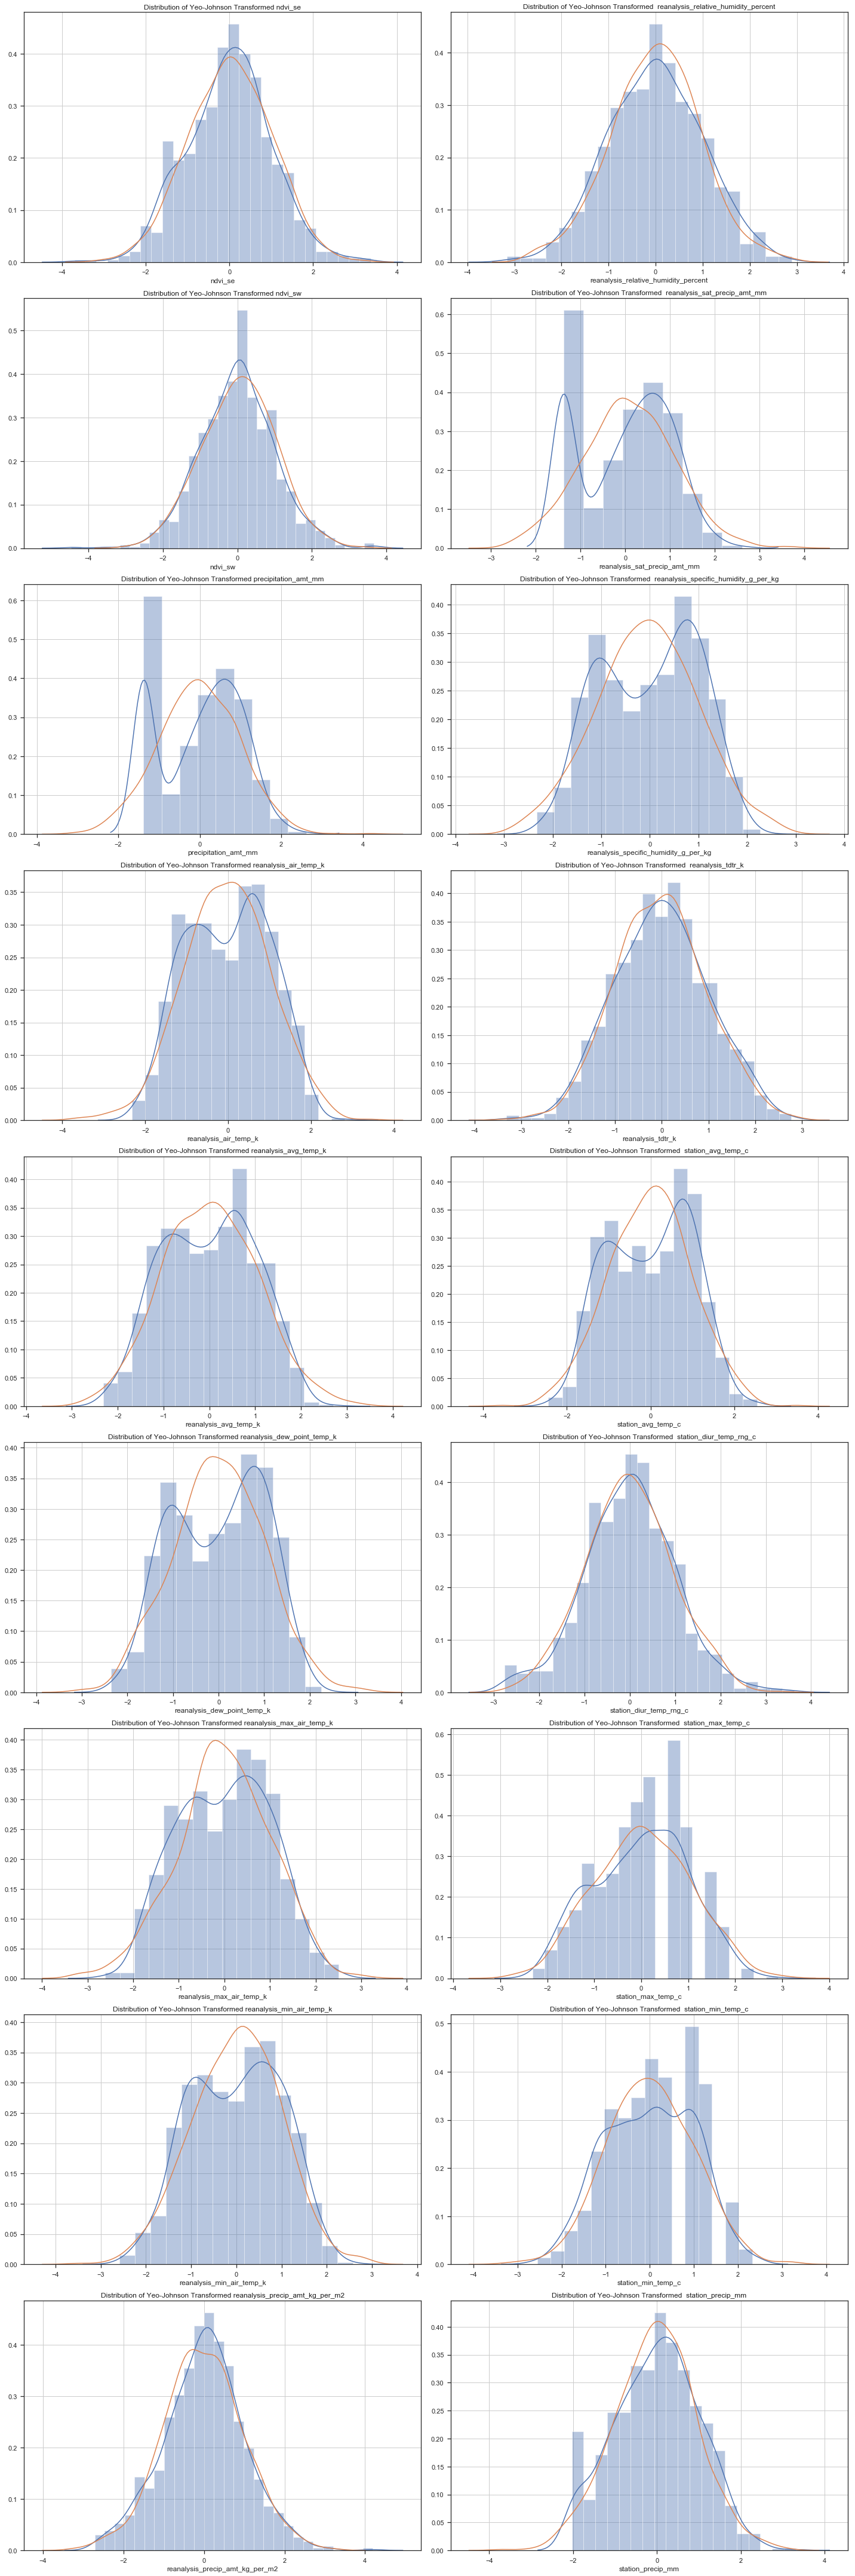

In [8]:
plot_pwr_dist(sj_X)

- __City iq:__

In [9]:
# Applying yeo-johnson transform on the features of City iq 
iq_X_pwr = PowerTransformer()
iq_X = pd.DataFrame(iq_X_pwr.fit_transform(iq_X), index=iq_X.index, columns=iq_X.columns)

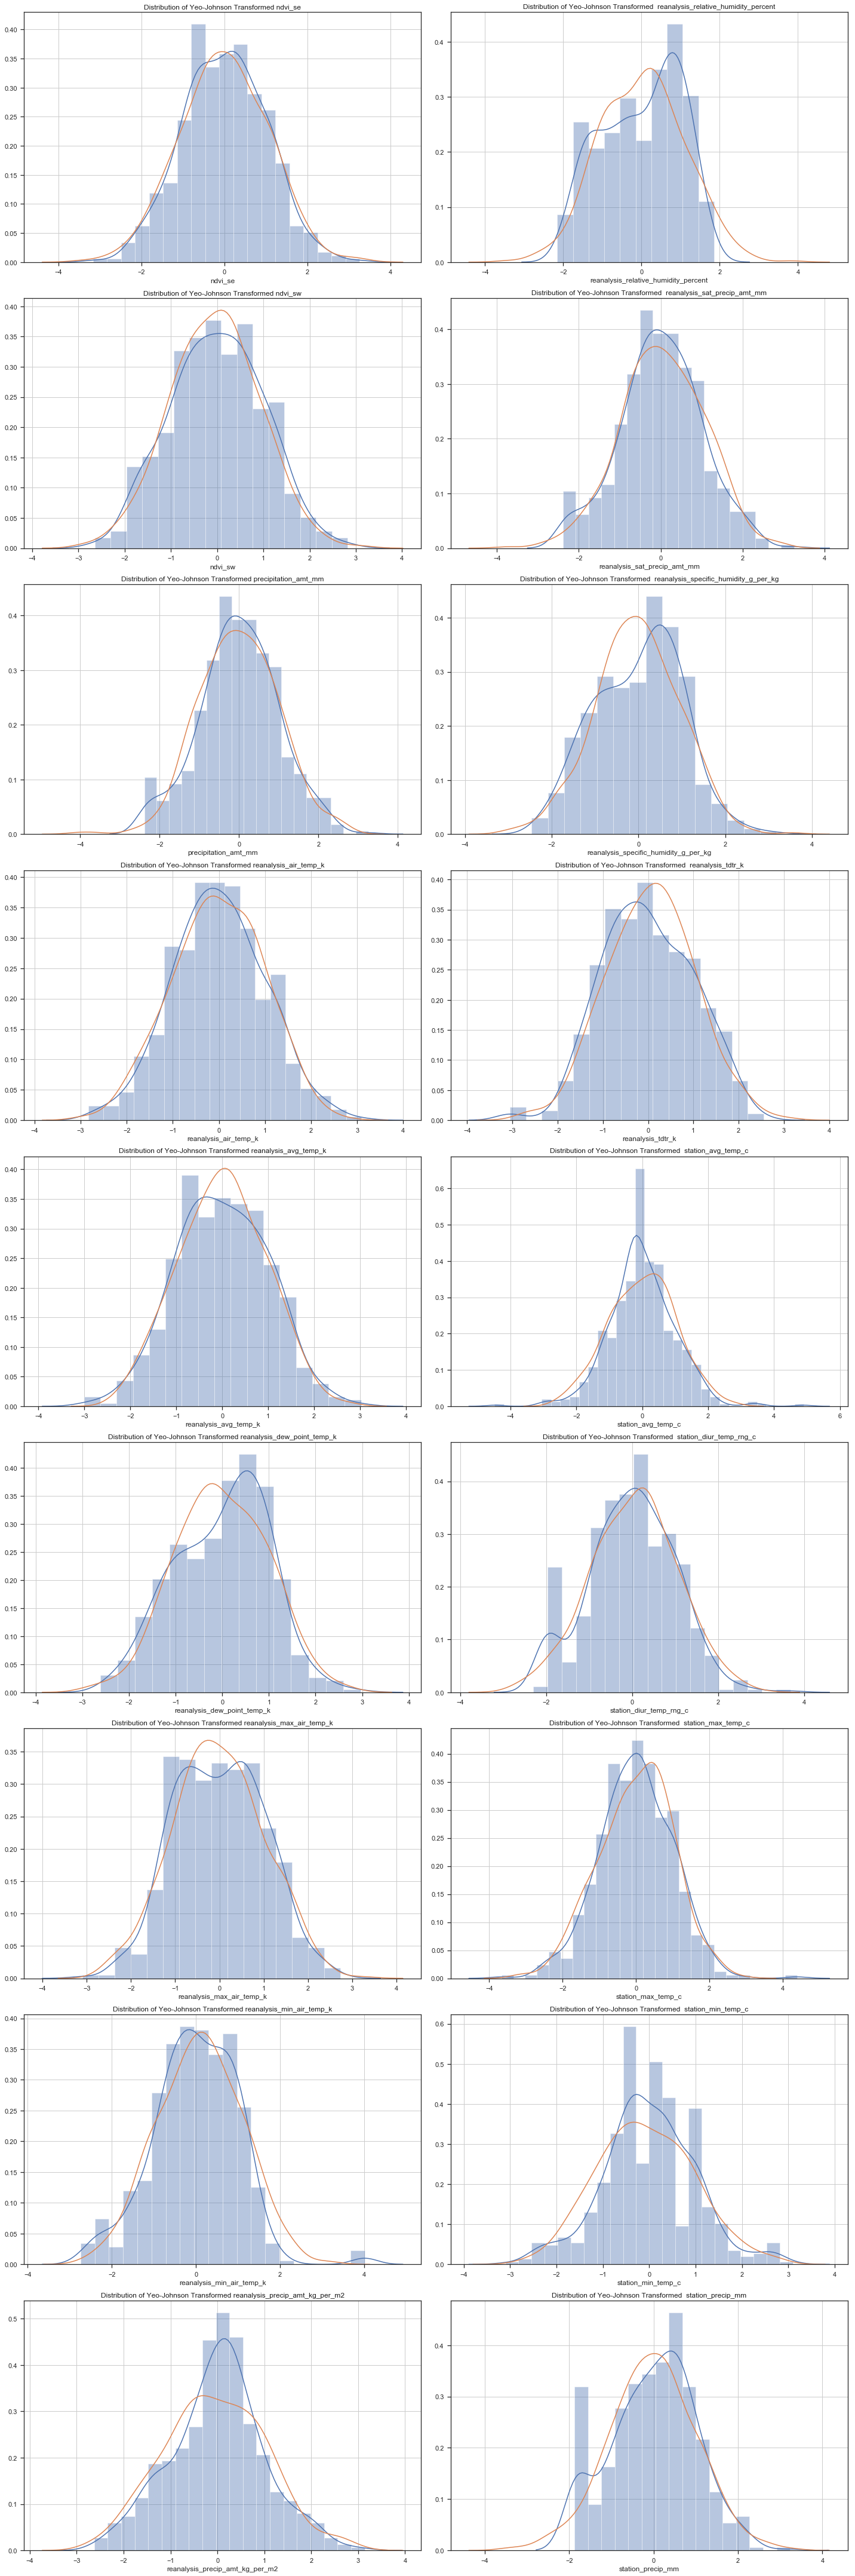

In [10]:
plot_pwr_dist(iq_X)

### 2. Seasonal Difference
__We will add the `ROLLING MOVING AVERAGE` and `PREVIOUS TIME STEP TOTAL NUMBER OF DENGUE CASES` of each feature from the previous timesteps in order to account for how data from previous timesteps also affect the total number of dengue cases in the current timestep.__

In [11]:
sj_X.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,
1990-04-30,0.703406,0.421506,0.420211,0.225938,-0.133201,-1.267007,-1.243194,-1.551243,-1.257668,-1.111277,0.460331,-1.502762,-0.133201,-1.513467,0.355365,-1.112537,0.189064,-1.268181,-1.611465,-0.041619
1990-05-07,1.196206,0.848595,-0.201284,-0.173025,0.226922,-0.805626,-0.726555,-0.857927,-0.434258,-0.791699,-0.133577,-0.385129,0.226922,-0.843269,-0.180430,-0.289741,-0.446716,-0.049699,-0.358533,-0.525588
1990-05-14,-0.240230,1.191405,-0.292164,0.104414,0.500156,-0.369180,-0.386707,0.059014,-0.740325,-0.131313,0.245261,1.039584,0.500156,0.075226,-0.342842,-0.289741,-0.308256,0.261982,0.044281,0.840314
1990-05-21,0.766309,1.996750,0.902026,1.250635,-0.012904,-0.205712,-0.103079,-0.029182,-0.040648,-0.364483,-0.378643,0.502897,-0.012904,-0.045552,-0.054986,0.261100,0.035477,1.013376,0.401642,-1.022056
1990-05-28,1.469873,2.188653,1.282453,1.447868,-0.393966,0.231798,0.263764,0.348824,0.365561,0.031905,-0.499831,0.540753,-0.393966,0.333943,1.039884,1.473942,3.026931,2.369253,0.857563,-0.795083


In [12]:
sj_X.rolling(window=2).mean().head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,
1990-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-07,0.949806,0.635050,0.109464,0.026456,0.046860,-1.036316,-0.984875,-1.204585,-0.845963,-0.951488,0.163377,-0.943946,0.046860,-1.178368,0.087467,-0.701139,-0.128826,-0.658940,-0.984999,-0.283604
1990-05-14,0.477988,1.020000,-0.246724,-0.034306,0.363539,-0.587403,-0.556631,-0.399456,-0.587292,-0.461506,0.055842,0.327227,0.363539,-0.384022,-0.261636,-0.289741,-0.377486,0.106142,-0.157126,0.157363
1990-05-21,0.263039,1.594077,0.304931,0.677524,0.243626,-0.287446,-0.244893,0.014916,-0.390486,-0.247898,-0.066691,0.771241,0.243626,0.014837,-0.198914,-0.014321,-0.136390,0.637679,0.222962,-0.090871
1990-05-28,1.118091,2.092701,1.092240,1.349251,-0.203435,0.013043,0.080342,0.159821,0.162457,-0.166289,-0.439237,0.521825,-0.203435,0.144195,0.492449,0.867521,1.531204,1.691314,0.629602,-0.908569


In [13]:
# # Create the new columns we want to incorporate into model
# # Add the rolling means for 1 week window to 8 week window
# for window in range(1, 9):
#     sj_X_n_week_rolling_mean = sj_X.rolling(window=window+1).mean()
#     sj_X_n_week_rolling_mean.columns = [col_name + '_rolling_{}_week'.format(window) for col_name in sj_X_n_week_rolling_mean.columns]

# #     sj_y_n_week_prior_cases = sj_y.shift(window)
# #     sj_y_n_week_prior_cases.name = '{}_week_prior_cases'.format(window)

#     sj_X = pd.concat([sj_X, 
#                       sj_X_n_week_rolling_mean], axis=1)

# # Rolling means with prior number of cases
# # sj_X = pd.concat([sj_X, 
# #                   sj_X_1_week_rolling_mean, 
# #                   sj_X_2_week_rolling_mean, 
# #                   sj_y_1_week_prior_cases, 
# #                   sj_y_2_week_prior_cases], axis=1).dropna(axis=0)

# sj_X = sj_X.dropna(axis=0)
# sj_X.head()

In [14]:
# # Create the new columns we want to incorporate into model
# # Add the rolling means for 1 week window to 8 week window
# for window in range(1, 9):
#     iq_X_n_week_rolling_mean = iq_X.rolling(window=window+1).mean()
#     iq_X_n_week_rolling_mean.columns = [col_name + '_rolling_{}_week'.format(window) for col_name in iq_X_n_week_rolling_mean.columns]

# #     sj_y_n_week_prior_cases = sj_y.shift(window)
# #     sj_y_n_week_prior_cases.name = '{}_week_prior_cases'.format(window)

#     iq_X = pd.concat([iq_X, 
#                       iq_X_n_week_rolling_mean], axis=1)

# # Rolling means with prior number of cases
# # sj_X = pd.concat([sj_X, 
# #                   sj_X_1_week_rolling_mean, 
# #                   sj_X_2_week_rolling_mean, 
# #                   sj_y_1_week_prior_cases, 
# #                   sj_y_2_week_prior_cases], axis=1).dropna(axis=0)

# iq_X = iq_X.dropna(axis=0)
# iq_X.head()

### 3. Trend Difference

---
<a id="featselect"></a>

## Feature Selection

__Before continuing to normalize and then standardize our data, let's squash our features to a lower dimensional space. This could be done using either Principal Component Analysis (PCA) or Linear Discriminant Analysis (LDA), but here we will use PCA.__

### Principal Component Analysis

In [15]:
# We will perform PCA here using the original features,
# not the new feature set after removing features for
# multicollinearity using VIF
from sklearn import decomposition

sj_pca = decomposition.PCA(n_components=1)

# PCA on City sj features
sj_X_pca = sj_pca.fit_transform(sj_X)

iq_pca = decomposition.PCA(n_components=1)

# PCA on City iq features
iq_X_pca = iq_pca.fit_transform(iq_X)

In [16]:
print("City sj features shape BEFORE: {}, after: {}".format(sj_X.shape, sj_X_pca.shape))
print("City sj target shape:", sj_y.shape)

print("City iq features shape BEFORE: {}, after: {}".format(iq_X.shape, iq_X_pca.shape))
print("City iq target shape:", iq_y.shape)

City sj features shape BEFORE: (936, 20), after: (936, 1)
City sj target shape: (936,)
City iq features shape BEFORE: (520, 20), after: (520, 1)
City iq target shape: (520,)


### 4. Standardization

In [17]:
# Import standard scaler module
from sklearn.preprocessing import StandardScaler

# Scale City sj features
sj_X_std_scaler = StandardScaler()
sj_X_scaled = sj_X_std_scaler.fit_transform(sj_X_pca)

# Scale City iq features
iq_X_std_scaler = StandardScaler()
iq_X_scaled = iq_X_std_scaler.fit_transform(iq_X_pca)

### 5. Normalization

In [18]:
# Import minmax scaler module
from sklearn.preprocessing import MinMaxScaler

# Scale City sj features
sj_X_norm_scaler = MinMaxScaler()
sj_X_normed = sj_X_norm_scaler.fit_transform(sj_X_scaled)

# Scale City iq features
iq_X_norm_scaler = MinMaxScaler()
iq_X_normed = iq_X_norm_scaler.fit_transform(iq_X_scaled)

---

## Training with Transformed Features
__Now let's start training all the previous models we used in Part 2 with the transformed features__

In [33]:
# Import models and utilities from sklearn
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
from time import time

# Let's define a function that'll settle the training
# testing pipeline for us
def train(X, y, mods, pwr):
    """
    Handles the entire train and testing pipeline
    
    Parameters:
    -----------
    X: (pandas.DataFrame) Feature columns
    y: (pandas.DataFrame) Labels
    mods: (list) List of sklearn models to be trained on
    pwr: yeo-johnson Transformer that was used to transform y
    
    Returns:
    --------
    DataFrame of results of training and also a dictionary of the trained models
    """
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Initialize models dictionary
    trained_mods = {str(mod())[:str(mod()).find('(')]: mod for mod in mods}
    
    # Initialize model performance dictionary
    performance_mods = {str(mod())[:str(mod()).find('(')]: defaultdict(float) for mod in mods}
    
    # Split into training and testing sets using KFold cross validation
    kf = KFold(n_splits=20, shuffle=False, random_state=42)
    
    # Loop through all models
    for idx, (mod_name, mod) in enumerate(trained_mods.items()):
        
        # Trained Model
        trained_mod = None
        
        # List of each score we get from each fold training / testing
        mse_train_scores = []
        mae_train_scores = []
        r2_train_scores = []
        mse_test_scores = []
        mae_test_scores = []
        r2_test_scores = []
        
        # Go through each fold in the KFold cross validation
        for train_index, test_index in kf.split(X):
            
            # Train Test Splits
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            ################
            ### TRAINING ###
            ################
            # Initialize current model
            curr_mod = mod()

            # Fit the model
            trained_mod = curr_mod.fit(X_train, y_train) 
            
            # Prediction scores for training set
            y_train_pred = pwr.inverse_transform(trained_mod.predict(X_train)[:,None]).astype(int)
            mse_train_scores.append(mean_squared_error(y_train, y_train_pred))
            mae_train_scores.append(mean_absolute_error(y_train, y_train_pred))
            r2_train_scores.append(r2_score(y_train, y_train_pred)) 
        
            ###############
            ### TESTING ###
            ###############
            # Prediction scores for testing set
            y_test_pred = pwr.inverse_transform(trained_mod.predict(X_test)[:,None]).astype(int)
            mse_test_scores.append(mean_squared_error(y_test, y_test_pred))
            mae_test_scores.append(mean_absolute_error(y_test, y_test_pred))
            r2_test_scores.append(r2_score(y_test, y_test_pred)) 
        
        # Saving average train scores
        performance_mods[mod_name]['train_' + str(mean_squared_error.__name__)] = np.mean(mse_train_scores)
        performance_mods[mod_name]['train_' + str(mean_absolute_error.__name__)] = np.mean(mae_train_scores)
        performance_mods[mod_name]['train_' + str(r2_score.__name__)] = np.mean(r2_train_scores)
        
        # Saving average test scores
        performance_mods[mod_name]['test_' + str(mean_squared_error.__name__)] = np.mean(mse_test_scores)
        performance_mods[mod_name]['test_' + str(mean_absolute_error.__name__)] = np.mean(mae_test_scores)
        performance_mods[mod_name]['test_' + str(r2_score.__name__)] = np.mean(r2_test_scores)
        
        # Saving last trained model
        trained_mods[mod_name] = trained_mod
            
    return performance_mods, trained_mods

In [34]:
# Let's declare the list of models we want to train
mods_to_train = [LinearRegression, BayesianRidge, ElasticNet, GaussianProcessRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, KernelRidge, SVR, MLPRegressor]

In [35]:
# City SJ
sj_performance_mods, sj_trained_mods = train(sj_X_normed, sj_y, mods_to_train, sj_pwr)
pd.DataFrame.from_dict(sj_performance_mods).transpose()

,test_mean_absolute_error,test_mean_squared_error,test_r2_score,train_mean_absolute_error,train_mean_squared_error,train_r2_score
LinearRegression,18.861655,377.965704,-410.565839,18.881462,378.598740,-377.666691
BayesianRidge,18.845837,376.392880,-409.044621,18.862231,377.034093,-376.101413
ElasticNet,18.050046,326.874573,-354.340496,18.050000,326.848744,-325.910704
GaussianProcessRegressor,19.094865,404.441778,-440.118352,19.175321,411.608891,-410.674058
RandomForestRegressor,25.499168,1360.138378,-1483.003349,25.441261,1262.796116,-1261.611180
AdaBoostRegressor,19.005480,409.149538,-446.890823,19.080035,410.942970,-409.944486
GradientBoostingRegressor,19.799791,489.938971,-544.053235,19.936497,487.510916,-486.574667
KernelRidge,16.480342,272.966722,-295.642156,16.487125,273.175848,-272.238558
SVR,19.492761,402.530416,-437.649922,19.506349,403.276845,-402.369042
MLPRegressor,18.886146,382.446350,-416.468768,18.898629,382.799230,-381.877429


In [36]:
# City IQ
iq_performance_mods, iq_trained_mods = train(iq_X_normed, iq_y, mods_to_train, iq_pwr)
pd.DataFrame.from_dict(iq_performance_mods).transpose()

,test_mean_absolute_error,test_mean_squared_error,test_r2_score,train_mean_absolute_error,train_mean_squared_error,train_r2_score
LinearRegression,3.544215,14.495449,-15.288360,3.550288,14.500890,-13.505659
BayesianRidge,3.530754,14.314003,-15.033050,3.535916,14.310972,-13.315649
ElasticNet,3.150000,11.166398,-11.316103,3.150000,11.043874,-10.050910
GaussianProcessRegressor,3.650175,16.291489,-17.111802,3.620086,15.153043,-14.157481
RandomForestRegressor,5.457576,70.156277,-79.111722,5.090472,48.902960,-47.918521
AdaBoostRegressor,3.634600,14.892825,-15.767551,3.610432,14.518433,-13.525008
GradientBoostingRegressor,3.858595,20.637736,-22.114269,3.812247,17.230560,-16.235364
KernelRidge,2.994231,9.971601,-10.017791,2.994332,9.967875,-8.970040
SVR,4.084600,18.939334,-20.290275,4.081462,18.877207,-17.884865
MLPRegressor,3.526908,14.192131,-14.881601,3.531273,14.209774,-13.214851


__Seems like with the rolling means and prior number of cases for previous timesteps added, KernelRidge is now performing the best overall, so let's use that on the competition test features and use the KernelRidge predictions as our next submission.__

<a id="test"></a>

---
## Competition Test Prediction

__Here we will use the KernelRidge model in order to predict the labels given the competition's test features__

In [37]:
test_feats_df = pd.read_csv('./data/dengai/test_features/dengue_features_test.csv', index_col='week_start_date')
test_feats_df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,sj,2008,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,sj,2008,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,sj,2008,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,sj,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,sj,2008,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


### Clean Data Pipeline

In [38]:
# Taking care of missing data
test_feats_df.fillna(test_feats_df.mode().iloc[0], inplace=True)

# Drop unecessary feature columns
test_feats_df = test_feats_df.drop(['year', 'weekofyear'], axis=1)

# Split dataset to City sj and City iq
test_sj_X = test_feats_df[test_feats_df['city'] == 'sj'].drop(['city'], axis=1)
test_sj_X.index = pd.to_datetime(test_sj_X.index)

test_iq_X = test_feats_df[test_feats_df['city'] == 'iq'].drop(['city'], axis=1)
test_iq_X.index = pd.to_datetime(test_iq_X.index)

### Feature Transformations

In [39]:
def transform_feats(X, pwr, pca, std_scaler, norm_scaler):
    """
    Transforms the features and returns the transformed numpy array
    
    Parameters:
    -----------
    X: (numpy.array) Feature columns that need to be transformed
    
    Returns:
    --------
    A numpy array with transformed features
    """
    # Transform features to be more normal
    X = pwr.transform(X)
    
    # Apply PCA
    X_pca = pca.transform(X)
    
    # Standardize
    X_scaled = std_scaler.transform(X_pca)
    
    # Normalize
    X_normed = norm_scaler.transform(X_scaled)
    
    return X_normed

### Prediction

In [40]:
test_sj_y_pred = sj_pwr.inverse_transform(sj_trained_mods['KernelRidge'].predict(transform_feats(test_sj_X, sj_X_pwr, sj_pca, sj_X_std_scaler, sj_X_norm_scaler))[:,None])
test_iq_y_pred = iq_pwr.inverse_transform(iq_trained_mods['KernelRidge'].predict(transform_feats(test_iq_X, iq_X_pwr, iq_pca, iq_X_std_scaler, iq_X_norm_scaler))[:,None])

In [41]:
# Save the results to csv and upload to competition
submission_df = pd.read_csv('./data/dengai/submission_format.csv')
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [42]:
sj_submission_df = submission_df[submission_df['city'] == 'sj'].drop(['total_cases'], axis=1)
sj_submission_df.reset_index(inplace=True)
sj_submission_df = pd.concat([sj_submission_df, pd.DataFrame(test_sj_y_pred.flatten().astype(int), columns=['total_cases'])], axis=1)
sj_submission_df.index = sj_submission_df['index']
sj_submission_df.drop(['index'], axis=1, inplace=True)
sj_submission_df.head()

,city,year,weekofyear,total_cases
index,,,,
0,sj,2008,18,16
1,sj,2008,19,16
2,sj,2008,20,16
3,sj,2008,21,16
4,sj,2008,22,16


In [43]:
iq_submission_df = submission_df[submission_df['city'] == 'iq'].drop(['total_cases'], axis=1)
iq_submission_df.reset_index(inplace=True)
iq_submission_df = pd.concat([iq_submission_df, pd.DataFrame(test_iq_y_pred.flatten().astype(int), columns=['total_cases'])], axis=1)
iq_submission_df.index = iq_submission_df['index']
iq_submission_df.drop(['index'], axis=1, inplace=True)
iq_submission_df.head()

,city,year,weekofyear,total_cases
index,,,,
260,iq,2010,26,3
261,iq,2010,27,3
262,iq,2010,28,3
263,iq,2010,29,3
264,iq,2010,30,3


In [44]:
submission_df = pd.concat([sj_submission_df, iq_submission_df], axis=0).reset_index().drop(['index'], axis=1)
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,16
1,sj,2008,19,16
2,sj,2008,20,16
3,sj,2008,21,16
4,sj,2008,22,16


In [45]:
# Save to csv
submission_df.to_csv('./data/dengai/kernelridge_submission.csv', index=False)

__This received an MAE score of 29.5577 in the competition, hinting that we might have overfitted our model...__

In [46]:
# test_sj_y_pred = sj_pwr.inverse_transform(sj_trained_mods['ElasticNet'].predict(transform_feats(test_sj_X))[:,None])
# test_iq_y_pred = iq_pwr.inverse_transform(iq_trained_mods['ElasticNet'].predict(transform_feats(test_iq_X))[:,None])

# # Save the results to csv and upload to competition
# submission_df = pd.read_csv('./data/dengai/submission_format.csv')

# sj_submission_df = submission_df[submission_df['city'] == 'sj'].drop(['total_cases'], axis=1)
# sj_submission_df.reset_index(inplace=True)
# sj_submission_df = pd.concat([sj_submission_df, pd.DataFrame(test_sj_y_pred.flatten().astype(int), columns=['total_cases'])], axis=1)
# sj_submission_df.index = sj_submission_df['index']
# sj_submission_df.drop(['index'], axis=1, inplace=True)

# iq_submission_df = submission_df[submission_df['city'] == 'iq'].drop(['total_cases'], axis=1)
# iq_submission_df.reset_index(inplace=True)
# iq_submission_df = pd.concat([iq_submission_df, pd.DataFrame(test_iq_y_pred.flatten().astype(int), columns=['total_cases'])], axis=1)
# iq_submission_df.index = iq_submission_df['index']
# iq_submission_df.drop(['index'], axis=1, inplace=True)

# submission_df = pd.concat([sj_submission_df, iq_submission_df], axis=0).reset_index().drop(['index'], axis=1)

# # Save to csv
# submission_df.to_csv('./data/dengai/elasticnet_submission.csv', index=False)

__Using the Elasticnet model, we got an MAE of 29.2212, supporting the fact that we are definitely overfitting our models to the current distribution of data that we have, perhaps we should increase the number of components after PCA...__